# Kolmogorov Flow Study


In [ ]:
import numpy as np
import torch 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pickle

latex_textwidth_in_inches = 6.5  # change as needed
px_width = latex_textwidth_in_inches * 96
template = "simple_white"
font=dict(family="Times New Roman", size=11)
default_colors = px.colors.qualitative.T10
figure_path = r"C:\Users\Noahc\Documents\USYD\PHD\4 - Latex_new\00_figures\06_mno\kf"

In [2]:
import sys
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909')
from utilities import PCA, w_to_u

In [93]:
# For 3D PCA scatter plots
pca_scene_dict = {'aspectmode':"manual", 
              'aspectratio':{'x':1,'y':1,'z':1.5},
              'xaxis':{'title':"1st PC"},
              'yaxis':{'title':"2nd PC"},
              'zaxis':{'title':"t"},}
pca_scene_camera = {'projection':{'type':"orthographic"},
                'up':{'x':0,'y':0,'z':1},
                'eye':{'x':0.5,'y':0.5,'z':0.5},
                'center':{'x':0.1,'y':0,'z':-0.1}
    }

## $Re=40$

In [217]:
re40_path = r"C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies\2D_NS_Re40.npy"
dataset = np.load(re40_path)
print(f'Dataset has shape {dataset.shape}')
out_dim = 1
S = 64
dataset[:,100:,...].reshape(-1,S,S)

#max_norm = np.linalg.norm(dataset[:,100:,...], axis=(2, 3)).max()
max_norm = 270.7950466198188

Dataset has shape (200, 501, 64, 64)


models:

In [219]:
models = {'Dataset':{'data': torch.tensor(dataset)},
          'Spectral_H0':{'wandb_name': "classic-sweep-10"},
          'Spectral_H1':{'wandb_name': "different-sweep-11"},
          'Spectral_H2':{'wandb_name': "crimson-sweep-12"},
          'Spectral_H0_reg':{'wandb_name': "summer-sweep-1"},
          'Spectral_H1_reg':{'wandb_name': "volcanic-sweep-2"},
          'Spectral_H2_reg':{'wandb_name': "gallant-sweep-3"},
          }

sweep_path1 = r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\results\ACFR'
for key,__ in models.items():
    models[key]['name'] = key

In [211]:
import os
from pathlib import Path
def fetch_results_path(models, level1_path=None, dictkey='wandb_name'):
    if level1_path is None:
        level1_path = os.getcwd()
        print(f'Searching for model exports in {level1_path}')
    level1_path = Path(level1_path)
    
    for key, value in models.items():
        if key == 'Dataset': continue
        run_path = None
        #wandb_name = value[dictkey].copy()

        for folder in level1_path.iterdir():
            if folder.is_dir() and folder.name.startswith(value[dictkey]):
                run_path = folder
                break
        
        if run_path is None:
            for level2_path in level1_path.iterdir():
                level2_path = Path(level2_path)
                if level2_path.is_dir():
                    for folder in level2_path.iterdir():
                        if folder.is_dir() and folder.name.startswith(value[dictkey]):
                            run_path = folder
                            break
        
        if run_path is None:
            print(f'{key} not found :(')
        else:
            models[key]['run_path'] = run_path
            print(f'{key} found at {run_path}')

fetch long rollout

In [220]:
solution_filename = 'long_rollout_sample.npy'
fetch_results_path(models, level1_path=sweep_path1)
for key, value in models.items():
    try:
        models[key]['data'] = torch.tensor(np.load(f'{value["run_path"]}/{solution_filename}'))
        T = models[key]["data"].shape[0] # set T for total study
        print(f'{key} has solution size {models[key]["data"].shape}')
    except:
        print(f'{key} has no solution path')

Spectral_H0 found at C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\results\ACFR\SWEEP-4i397axx\classic-sweep-10-b7c0vm06
Spectral_H1 found at C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\results\ACFR\SWEEP-4i397axx\different-sweep-11-fqnkg44t
Spectral_H2 found at C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\results\ACFR\SWEEP-4i397axx\crimson-sweep-12-9v9jg1qs
Spectral_H0_reg found at C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\results\ACFR\SWEEP-4i397axx\summer-sweep-1-swgstplh
Spectral_H1_reg found at C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\results\ACFR\SWEEP-4i397axx\volcanic-sweep-2-6cxka8yc
Spectral_H2_reg found at C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\results\ACFR\SWEEP-4i397axx\gallant-sweep-3-yhch2bfb
Dataset has no solution path
Spectral_H0 has solution size torch.Size([301, 64, 64, 1])
Spectral_H1 has solution size torch.Size([301, 64, 64, 1])
Spectral_H2 has solution size torch.Size([301, 64, 64, 1])
Spectral_H0_reg has s

### PCA Statistics

In [221]:
use_preloaded_encoding = True
save_new_encoding = False
encoding_folder = r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\data'

PCA_dim = 50
if use_preloaded_encoding:
    with open(f"{encoding_folder}/x_pca_kf_re40.pkl", "rb") as f:
        x_pca = pickle.load(f)
else:
    x_pca = PCA(torch.tensor(dataset).reshape(-1, 64*64), PCA_dim, subtract_mean=False)
    if save_new_encoding:
        with open(f"{encoding_folder}/x_pca_kf_re40.pkl", "wb") as f:
            pickle.dump(x_pca, f)

In [222]:
#T = 10000
for key, value in models.items():
    models[key]['pca_encoding'] = x_pca.encode(value['data'].reshape(-1, 64*64))[:T]

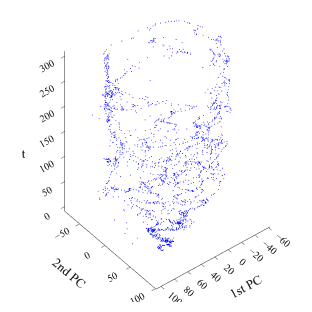

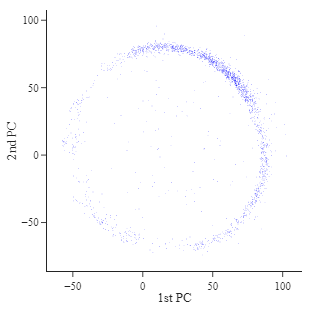

In [223]:
fig_3d = go.Figure()
fig_2d = go.Figure()
n_T = 10000

for key, value in models.items():
    fig_3d.add_trace(go.Scatter3d(x=value['pca_encoding'][:n_T, 0], 
                               y=value['pca_encoding'][:n_T, 1], 
                               z=np.arange(n_T), 
                               name=value['name'], legendgroup=value['name'],
                               mode='markers', marker=dict(size=0.5, color='blue')
                               ))
    fig_2d.add_trace(go.Scatter(x=value['pca_encoding'][:n_T, 0], 
                               y=value['pca_encoding'][:n_T, 1], 
                               #z=np.arange(n_T), 
                               name=value['name'], legendgroup=value['name'],
                               mode='markers', marker=dict(size=0.5, color='blue')
                               ))
fig_3d.update_layout(
    font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=False,
    width=px_width/2, height = px_width/2, margin=dict(l=0, r=0, t=10, b=10),
    scene=pca_scene_dict, scene_camera=pca_scene_camera
)
fig_2d.update_layout(
    font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=False,
    width=px_width/2, height = px_width/2, margin=dict(l=10, r=10, t=10, b=10),
    xaxis={'title_text':"1st PC", 'title_standoff':1}, 
    yaxis={'title_text':"2nd PC", 'title_standoff':1}
    #scene=pca_scene_dict, scene_camera=pca_scene_camera
)
fig_3d.show(renderer="png")
fig_2d.show(renderer="png")

Now lets plot the dissipation regularizer:

### Vorticity distribution

In [229]:
from scipy.stats import gaussian_kde
n_bins = 50
for key, value in models.items():
    kde_data = gaussian_kde(value['data'].reshape(-1)[np.random.permutation(len(value['data'].reshape(-1)))[:T]],
                            bw_method='scott')
    bins_data = np.linspace(value['data'].reshape(-1).min(), value['data'].reshape(-1).max(), n_bins)
    bins_data = np.linspace(-3, 3, n_bins)
    models[key]['vorticity_dist'] = kde_data.evaluate(bins_data)
    models[key]['vorticity_bins'] = bins_data

In [ ]:
fig = go.Figure()
show_model_list = ['Dataset', 'Spectral_H1_reg', 'Spectral_H0_reg', 'Spectral_H2_reg']
for key, value in models.items():
    if key not in show_model_list: continue
    fig.add_trace(go.Scatter(x=value['vorticity_bins'],
                             y=value['vorticity_dist'],
                             name=value['name'], legendgroup=value['name'],
                             mode='lines', line=dict(width=1)
                             ))
fig.update_layout(
    font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=True,
    width=px_width, height = px_width/2, margin=dict(l=10, r=10, t=10, b=10),
    xaxis={'title_text':"Vorticity", 'title_standoff':1, 'showgrid':True, 
           'range':[models['Dataset']['vorticity_bins'].min(), models['Dataset']['vorticity_bins'].max()]}, 
    yaxis={'title_text':"Density", 'title_standoff':1, 'showgrid':True}
)
fig.show()

### Energy Spectrum

In [121]:
def spectrum2(u, s):
    T = u.shape[0]
    u = u.reshape(T, s, s)
    u = torch.fft.fft2(u)

    # 2d wavenumbers following Pytorch fft convention
    k_max = s // 2
    wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1), \
                            torch.arange(start=-k_max, end=0, step=1)), 0).repeat(s, 1)
    k_x = wavenumers.transpose(0, 1)
    k_y = wavenumers
    
    # Sum wavenumbers
    sum_k = torch.abs(k_x) + torch.abs(k_y)
    sum_k = sum_k.numpy()
    
    # Remove symmetric components from wavenumbers
    index = -1.0 * np.ones((s, s))
    index[0:k_max + 1, 0:k_max + 1] = sum_k[0:k_max + 1, 0:k_max + 1]

    spectrum = np.zeros((T, s))
    for j in range(1, s + 1):
        ind = np.where(index == j)
        spectrum[:, j - 1] = np.sqrt( (u[:, ind[0], ind[1]].sum(axis=1)).abs() ** 2)
        
    spectrum = spectrum.mean(axis=0)
    return spectrum

In [127]:
for key, value in models.items():
    models[key]['spectrum'] = spectrum2(value['data'].reshape(-1,S,S), S)[:S//2]

In [131]:
fig = go.Figure()
for key, value in models.items():
    fig.add_trace(go.Scatter(y=value['spectrum'],
                             name=value['name'], legendgroup=value['name'],
                             mode='lines', line=dict(color='blue', width=1)
                             ))
fig.update_layout(
    font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=False,
    width=px_width/2, height = px_width/2, margin=dict(l=10, r=10, t=10, b=10),
    xaxis={'title_text':"Wavenumber", 'title_standoff':1, 'showgrid':False}, 
    yaxis={'title_text':"Energy", 'title_standoff':1, 'type':"log", 'showgrid':True}
)
fig.show()